In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.1378

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - loss: 0.1082
Average validation loss: 0.7064945101737976
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - loss: 0.1082 - val_loss: 0.7065
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step - loss: 0.0810 - val_loss: 0.7065
Average validation loss: 0.5806272625923157
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - loss: 0.0810 - val_loss: 0.6436
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 554ms/step - loss: 0.0623 - val_loss: 0.6436
Average validation loss: 0.4842623174190521
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 566ms/step - loss: 0.0623 - val_loss: 0.5905
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 864ms/step - loss: 3.8861e-04
Average validation loss: 0.20868881046772003
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 874ms/step - loss: 3.8861e-04 - val_loss: 0.2087
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 839ms/step - loss: 3.6853e-04 - val_loss: 0.2087
Average validation loss: 0.1310555599629879
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 849ms/step - loss: 3.6853e-04 - val_loss: 0.1699
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 810ms/step - loss: 3.5953e-04 - val_loss: 0.1699
Average validation loss: 0.14349986985325813
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 822ms/step - loss: 3.5953e-04 - val_loss: 0.1611
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 838ms/step - loss: 3.5407e-04 - val_loss: 0.1611
Averag

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 816ms/step - loss: 1.2945e-04
Average validation loss: 0.08774581054846446
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 826ms/step - loss: 1.2945e-04 - val_loss: 0.0877
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 842ms/step - loss: 1.1488e-04 - val_loss: 0.0877
Average validation loss: 0.07628425334890683
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 853ms/step - loss: 1.1488e-04 - val_loss: 0.0820
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 871ms/step - loss: 1.0729e-04 - val_loss: 0.0820
Average validation loss: 0.14999834448099136
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 880ms/step - loss: 1.0729e-04 - val_loss: 0.1047
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 879ms/step - loss: 1.0113e-04 - val_lo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 807ms/step - loss: 2.9893e-05
Average validation loss: 0.01815203740261495
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 818ms/step - loss: 2.9893e-05 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 875ms/step - loss: 2.7615e-05 - val_loss: 0.0182
Average validation loss: 0.04863549070432782
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 886ms/step - loss: 2.7615e-05 - val_loss: 0.0334
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 814ms/step - loss: 3.1564e-05 - val_loss: 0.0334
Average validation loss: 0.022977119544520974
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 825ms/step - loss: 3.1564e-05 - val_loss: 0.0299
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 816ms/step - loss: 2.9810e-05 - val_loss: 0.0299
Average validation loss: 0.034447149373590946
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 827ms/step - loss: 2.9810e-05 - val_loss: 0.0311
Epoch 5/10
16

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 806ms/step - loss: 4.6099e-05
Average validation loss: 0.06480673030018806
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 816ms/step - loss: 4.6099e-05 - val_loss: 0.0648
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 817ms/step - loss: 4.1640e-05 - val_loss: 0.0648
Average validation loss: 0.07030839622020721
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 829ms/step - loss: 4.1640e-05 - val_loss: 0.0676
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 790ms/step - loss: 3.4146e-05 - val_loss: 0.0676
Average validation loss: 0.048035051114857195
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 802ms/step - loss: 3.4146e-05 - val_loss: 0.0611
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 807ms/step - loss: 2.9790e-05 - val_l

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 829ms/step - loss: 6.9252e-05
Average validation loss: 0.01782585944359501
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 840ms/step - loss: 6.9252e-05 - val_loss: 0.0178
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 844ms/step - loss: 6.5127e-05 - val_loss: 0.0178
Average validation loss: 0.01906443728754918
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 853ms/step - loss: 6.5127e-05 - val_loss: 0.0184
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 795ms/step - loss: 5.1088e-05 - val_loss: 0.0184
Average validation loss: 0.007271199467747162
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 805ms/step - loss: 5.1088e-05 - val_loss: 0.0147
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 795ms/step - loss: 4.2805e-05 - val_l

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 800ms/step - loss: 4.0713e-05
Average validation loss: 0.01664811682421714
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 811ms/step - loss: 4.0713e-05 - val_loss: 0.0166
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 779ms/step - loss: 3.0151e-05 - val_loss: 0.0166
Average validation loss: 0.026974333729594947
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 790ms/step - loss: 3.0151e-05 - val_loss: 0.0218
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 788ms/step - loss: 2.6671e-05 - val_loss: 0.0218
Average validation loss: 0.0157166343415156
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 799ms/step - loss: 2.6671e-05 - val_loss: 0.0198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_50.pth'.
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 127s 782ms/step - loss: 2.4039e-05 - val_l

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 794ms/step - loss: 2.5345e-05
Average validation loss: 0.007487402685607473
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 806ms/step - loss: 2.5345e-05 - val_loss: 0.0075
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 813ms/step - loss: 1.6045e-05 - val_loss: 0.0075
Average validation loss: 0.006839978343729551
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 825ms/step - loss: 1.6045e-05 - val_loss: 0.0072
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 800ms/step - loss: 1.2025e-05 - val_loss: 0.0072
Average validation loss: 0.012003995972918347
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 812ms/step - loss: 1.2025e-05 - val_loss: 0.0088
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 156s 794ms/step - loss: 9.8318e-06 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 800ms/step - loss: 1.0091e-05
Average validation loss: 0.00881632580421865
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 812ms/step - loss: 1.0091e-05 - val_loss: 0.0088
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 797ms/step - loss: 7.7830e-06 - val_loss: 0.0088
Average validation loss: 0.008868277954336787
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 809ms/step - loss: 7.7830e-06 - val_loss: 0.0088
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 139s 857ms/step - loss: 7.5310e-06 - val_loss: 0.0088
Average validation loss: 0.01928655761626682
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 869ms/step - loss: 7.5310e-06 - val_loss: 0.0123
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 188s 851ms/step - loss: 6.7417e-06 - val_loss: 0.0123
Average validation loss: 0.007655057873177741
56/56 ━━━━━━━━━━━━━━━━━━━━ 188s 862ms/step - loss: 6.7417e-06 - val_loss: 0.0112
Saved mod

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 811ms/step - loss: 7.8559e-06
Average validation loss: 0.01341194228734821
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 822ms/step - loss: 7.8559e-06 - val_loss: 0.0134
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 792ms/step - loss: 6.4852e-06 - val_loss: 0.0134
Average validation loss: 0.012247050239238888
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 804ms/step - loss: 6.4852e-06 - val_loss: 0.0128
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 792ms/step - loss: 5.7358e-06 - val_loss: 0.0128
Average validation loss: 0.010964507338940166
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 804ms/step - loss: 5.7358e-06 - val_loss: 0.0122
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 792ms/step - loss: 4.1009e-06
Average validation loss: 0.025551143542139068
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 803ms/step - loss: 4.1009e-06 - val_loss: 0.0256
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 795ms/step - loss: 3.6319e-06 - val_loss: 0.0256
Average validation loss: 0.014571447074154599
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 806ms/step - loss: 3.6319e-06 - val_loss: 0.0201
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 792ms/step - loss: 3.2175e-06 - val_loss: 0.0201
Average validation loss: 0.014428245880278863
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 802ms/step - loss: 3.2175e-06 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weight

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 791ms/step - loss: 5.7578e-06
Average validation loss: 0.006326848041499034
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 802ms/step - loss: 5.7578e-06 - val_loss: 0.0063
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 825ms/step - loss: 4.5108e-06 - val_loss: 0.0063
Average validation loss: 0.004977024553227238
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 835ms/step - loss: 4.5108e-06 - val_loss: 0.0057
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 805ms/step - loss: 3.6906e-06 - val_loss: 0.0057
Average validation loss: 0.019985528982942924
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 816ms/step - loss: 3.6906e-06 - val_loss: 0.0104
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 261s 813ms/step - loss: 3.3385e-0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 807ms/step - loss: 1.8685e-05
Average validation loss: 0.3586903177201748
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 819ms/step - loss: 1.8685e-05 - val_loss: 0.3587
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 778ms/step - loss: 1.4337e-05 - val_loss: 0.3587
Average validation loss: 0.012570329185109586
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 789ms/step - loss: 1.4337e-05 - val_loss: 0.1856
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 231s 803ms/step - loss: 1.1296e-05 - val_loss: 0.1856
Average validation loss: 0.059372326669593654
96/96 ━━━━━━━━━━━━━━━━━━━━ 232s 813ms/step - loss: 1.1296e-05 - val_loss: 0.1435
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 310s 810ms/step - loss: 9.4823e-06 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 794ms/step - loss: 2.3510e-05
Average validation loss: 0.01026012897103404
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 806ms/step - loss: 2.3510e-05 - val_loss: 0.0103
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 802ms/step - loss: 1.6649e-05 - val_loss: 0.0103
Average validation loss: 0.015818324708379804
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 813ms/step - loss: 1.6649e-05 - val_loss: 0.0130
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 805ms/step - loss: 1.3125e-05 - val_loss: 0.0130
Average validation loss: 0.009543002645174662
120/120 ━━━━━━━━━━━━━━━━━━━━ 292s 816ms/step - loss: 1.3125e-05 - val_loss: 0.0119
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 388s 793ms/step - lo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 799ms/step - loss: 1.4543e-05
Average validation loss: 0.008005647517469091
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 810ms/step - loss: 1.4543e-05 - val_loss: 0.0080
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 793ms/step - loss: 1.0569e-05 - val_loss: 0.0080
Average validation loss: 0.011202705015117923
144/144 ━━━━━━━━━━━━━━━━━━━━ 233s 804ms/step - loss: 1.0569e-05 - val_loss: 0.0096
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 346s 791ms/step - loss: 8.7485e-06 - val_loss: 0.0096
Average validation loss: 0.008926096736104228
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 802ms/step - loss: 8.7485e-06 - val_loss: 0.0094
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 462s 793ms/step - loss: 7.9985e-06 - val_loss: 0.0094
Average validation loss: 0.0074259879458825
144/144 ━━━━━━━━━━━━━━━━━━━━ 464s 804ms/step - loss: 7.9985e-06 - val_l

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 795ms/step - loss: 8.9996e-06
Average validation loss: 0.01594576649949886
160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 806ms/step - loss: 8.9996e-06 - val_loss: 0.0159
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 787ms/step - loss: 6.2865e-06 - val_loss: 0.0159
Average validation loss: 0.007219792532850988
160/160 ━━━━━━━━━━━━━━━━━━━━ 257s 799ms/step - loss: 6.2865e-06 - val_loss: 0.0116
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 382s 784ms/step - loss: 5.1363e-06 - val_loss: 0.0116
Average validation loss: 0.007275983993895352
160/160 ━━━━━━━━━━━━━━━━━━━━ 384s 795ms/step - loss: 5.1363e-06 - val_loss: 0.0101
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 513s 809ms/step - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 158s 792ms/step - loss: 5.5047e-06
Average validation loss: 0.010436140077727031
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 804ms/step - loss: 5.5047e-06 - val_loss: 0.0104
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 319s 790ms/step - loss: 4.2724e-06 - val_loss: 0.0104
Average validation loss: 0.00802507735977997
200/200 ━━━━━━━━━━━━━━━━━━━━ 321s 801ms/step - loss: 4.2724e-06 - val_loss: 0.0092
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 481s 798ms/step - loss: 3.5440e-06 - val_loss: 0.0092
Average validation loss: 0.00802483559516986
200/200 ━━━━━━━━━━━━━━━━━━━━ 483s 809ms/step - loss: 3.5440e-06 - val_loss: 0.0088
Saved model weights to 'c:\天_11157065\git\RipplesDetection\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 192s 799ms/step - loss: 4.9067e-06
Average validation loss: 0.006972645800851751
240/240 ━━━━━━━━━━━━━━━━━━━━ 195s 810ms/step - loss: 4.9067e-06 - val_loss: 0.0070
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 383s 786ms/step - loss: 3.6049e-06 - val_loss: 0.0070
Average validation loss: 0.006331397895276799
240/240 ━━━━━━━━━━━━━━━━━━━━ 386s 797ms/step - loss: 3.6049e-06 - val_loss: 0.0067
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 575s 790ms/step - loss: 3.2304e-06 - val_loss: 0.0067
Average validation loss: 0.007281914259025749
240/240 ━━━━━━━━━━━━━━━━━━━━ 578s 801ms/step - loss: 3.2304e-06 - val_loss: 0.0069
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 768s 794ms/step -

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.2733535322546959, 0.14236743649467826, 0.07278166866240401, 0.04357969220203813, 0.02595778661733493, 0.01786616172680321, 0.017697800354217183, 0.012507812022231522, 0.010800775899842846, 0.010102151244827837, 0.0194281424808691, 0.01816024433117127, 0.02501420024098479, 0.007396098889837352, 0.009860032517055958, 0.007586617197091158, 0.007175193483151881, 0.007314825132182323]
std_val_losses =  [0.1980634528422214, 0.12024343105718455, 0.05846316184976175, 0.035656312920158126, 0.01845673948726622, 0.016827445073233485, 0.010796375090988427, 0.011435816970259857, 0.008569262854295445, 0.0066161636810198885, 0.04036058449109377, 0.019666095904759175, 0.05369149689771581, 0.004493955464737113, 0.007118749218463945, 0.0038025567699250893, 0.0032310248517084914, 0.003392706824061059]


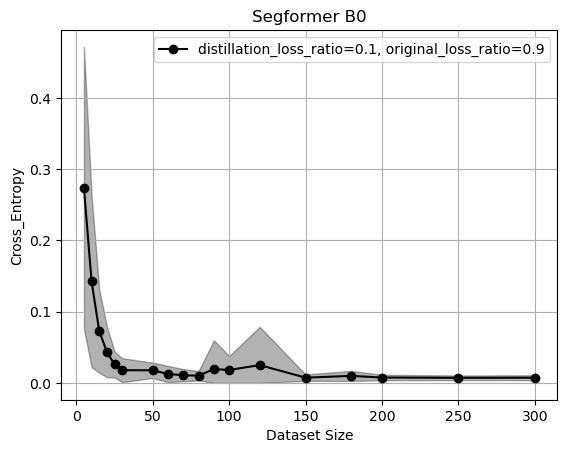

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()